# Exploratory Data Analysis

In this notebook, we will perform exploratory data analysis (EDA) on the MNIST dataset. We follow the procedure outlined in [David Robinson's article](http://varianceexplained.org/r/digit-eda/) and [Asad Kazmi's articke](https://www.linkedin.com/pulse/unveiling-patterns-mnist-dataset-asad-kazmi-o8glf/) while providing our own insights and conclusions. We load the MNIST dataset using _slowlearn_, my from-sctatch ML library, which finds the data in the files `MNIST-X.npy` and `MNIST-y.npy`.


In [1]:
# Importing,
import numpy as np
import matplotlib.pyplot as plt
from slowlearn.datasets import load_MNIST
from slowlearn.utils.Sampling import random_sample
from ipywidgets import interact
import ipywidgets as widgets
import seaborn as sns

# Loading dataset,
mnist = load_MNIST()
X, y = random_sample(X=mnist.X, y=mnist.y, n=1000, seed=0)
target_names = mnist.target_names

# Printing,

"""Add a representation of the mnist dataset."""

'Add a representation of the mnist dataset.'

Before proceeding, it is a good idea to inspect the distribution of classes in the data. From taking a random sample of the dataset, the classes seem to be evenly distributed within the dataset.

[]

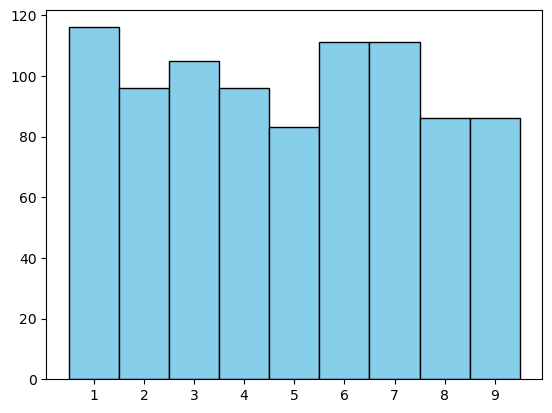

In [ ]:
# Plotting,
bins = [i - 0.5 for i in range(1, 11)] # <-- Custom bins.
plt.hist(y, color="skyblue", bins=bins, edgecolor="black")
plt.xticks(range(1, 10))
plt.plot()

## Visualisations

Let us firstly visualise the digits as images (add slider).

In [11]:
def plot_image(sample_idx):
    """Function to plot the digit image and its histogram using Matplotlib."""

    # Plotting,
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(X[sample_idx], cmap="gray") # <-- Image.
    axes[1].hist(X[sample_idx].flatten(), bins=10, color="black") # <-- Image histogram.
    #plt.plot()

    # Printing label,
    print(f"Label: {y[sample_idx]}")

# Setting up widget,
interact(plot_image, sample_idx=widgets.IntSlider(value=0, min=0, max=1000, step=1))

interactive(children=(IntSlider(value=0, description='sample_idx', max=1000), Output()), _dom_classes=('widget…

<function __main__.plot_image(sample_idx)>

Already, we have a few insights. We notice that it is much more difficult for us to distinguish between the digits from their pixel intensity histograms. This is not suprising since flattening the 2D image arrays removes spatial information completely. From the histogram of each digit image, we see that the majority of pixels have either the minimum intensity `0` or the maximum `255`. This means that there would be little loss of information if we were to convert these images into binary images. Now we want to see how the images of each digit vary across all samples of our subset. Averaging across the samples of a given class yields,

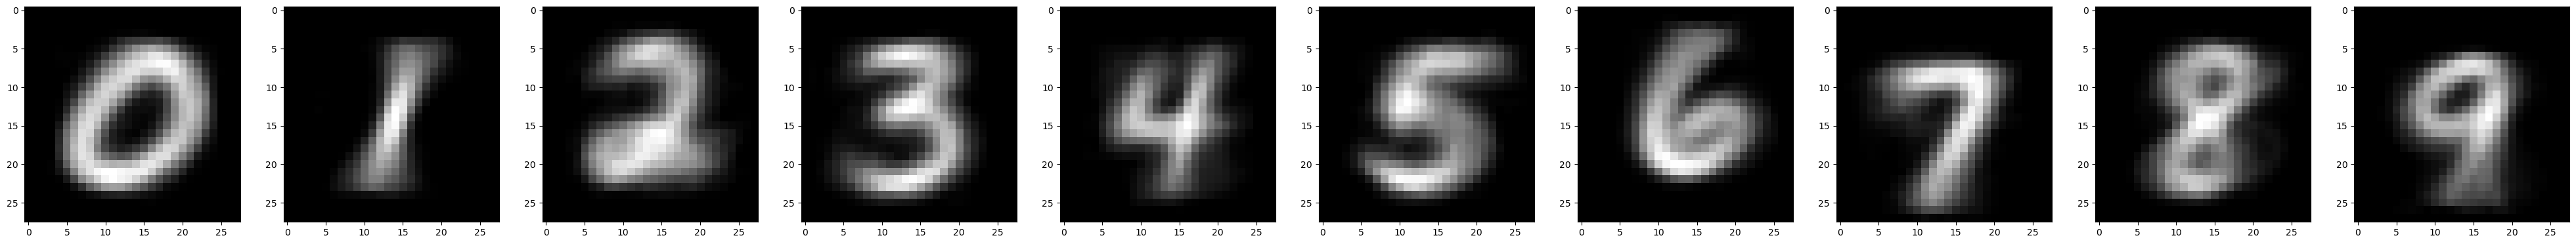

In [12]:
def compute_mean_digit(X, label):
    """Returns the mean image of all digits images of a given class across all samples."""
    X_class = X[np.where(y == label)[0]]
    mean_digit = np.mean(X_class, axis=0)
    return mean_digit

# Creating plot,
fig, axes = plt.subplots(1, 10, figsize=(50, 5))

# Computing all the mean digits,
for i in range(10):
    mean_digit = compute_mean_digit(X, label=i)
    axes[i].imshow(mean_digit, cmap="gray")

Qualitatively, there does not appear to be significant variance across samples belonging to the same digit class. Subjectively, it appears that samples of `1` or `2` are the most varied. Visualising samples belonging to those classes in particular, 

In [6]:
def plot_image_class(idx):
    """TBA"""

    # Plotting,
    class_label = 0
    class_idxs = np.where(y == class_label)[0]
    sample_idx = class_idxs[idx]
    fig, axes = plt.subplots(1, figsize=(5, 5))
    axes.imshow(X[sample_idx], cmap="gray") # <-- Image.
    plt.plot()

    # Printing label,
    print(f"sample_idx: {sample_idx}")
    print(f"Label:  {y[sample_idx]}")

# Setting up widget,
interact(plot_image_class, idx=widgets.IntSlider(value=0, min=0, max=75, step=1))

interactive(children=(IntSlider(value=0, description='idx', max=75), Output()), _dom_classes=('widget-interact…

<function __main__.plot_image_class(idx)>

Interesting, after iterating through enough samples, we find that people have different ways of drawing these digits. These different ways of drawing the same digit are the reason for the highest variance seen in the digits `1` and `2` compared to all other digits which are written in only a single form by people (with the exception of `4`). Even though there are two different ways of writing `4`, its samples does not have variance as large as the samples belonging to `1` or `2` since a single variant dominates over the other.

<img src="fig_1.png" width="500" height="500">

## Quantifying Variance and Correlation

Now we want to  quantify the variance of samples belonging to the same digit class mathematically rather than visually. The most straight forward way would be to calculate the MSE between a digit's centroid and all other samples of the same class. Say that $\hat{D}_k$ is a matrix that represents the centroid the $k$-th digit, we want to compute for all $k$,

$$
\text{MSE}(\hat{D}_k, D_k) = \sum_{i, j} (\hat{D}_k[i, j] -D_k[i, j])^2
$$

where $D_k$ is the image matrix of a given sample belgoning the the $k$-th digit class. We do this for all $D_k$ and inspect the distribution on a violin plot that provides a kernel density estimate,

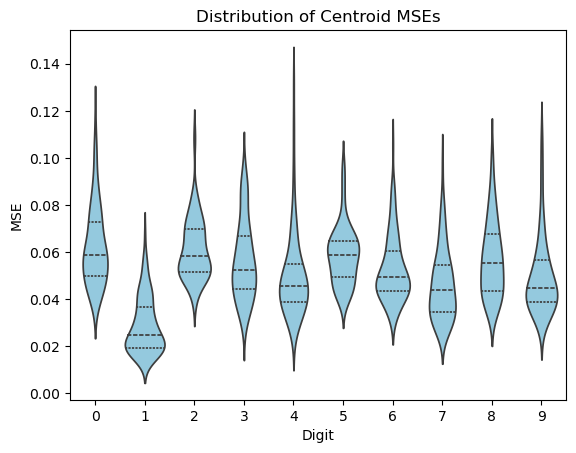

In [13]:
# Normalise the images (equivalent to min-max normalisation),
X_norm = X/255

# Computing all digit centroids,
digit_centroids = []
for i in range(10):
    mean_digit = compute_mean_digit(X_norm, label=i)
    digit_centroids.append(mean_digit)

# Computing centroid MSEs,
centroid_mses = []
for class_label in range(10):

    # Collecting all samples of a given class label,
    class_idxs = np.where(y == class_label)[0]

    # Computing MSEs between the samples of a given class and its respective centroid, 
    image_sqaured_diffs = (digit_centroids[class_label] - X_norm[class_idxs])**2
    mse = np.mean(image_sqaured_diffs, axis=(1, 2))
    centroid_mses.append(mse)

# Visualising via violin plot,
sns.violinplot(centroid_mses, inner="quart", color="skyblue")
plt.xlabel("Digit")
plt.ylabel("MSE")
plt.title("Distribution of Centroid MSEs")
plt.show()

It is clear to see that the digit `1` has the lowest variation amongst its samples comparble to all other digits. Digits `3`, `4`. `6`, `7`, `8` and `9` are similiar in their variability. Finally, `0`, `2` and `5` appear to be the most variable of the digits. Let us now consider how closely digits look like to one another,

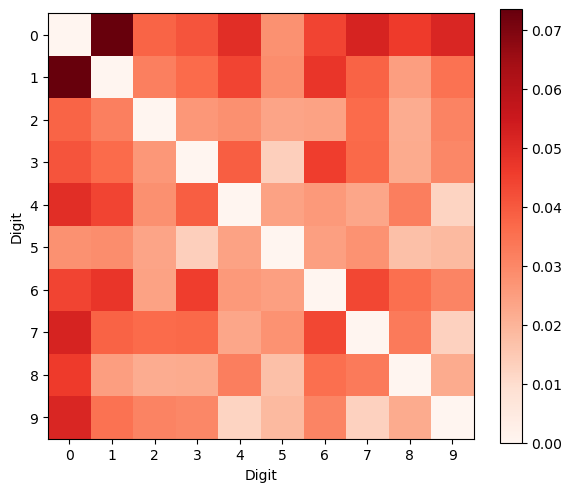

In [102]:
def VisualiseMatrix(matrix_array, class_labels):

    # Creating figure,
    plt.figure(figsize=(6, 5))
    im = plt.imshow(matrix_array, cmap="Reds")
    plt.colorbar(im)

    # Adding class labels on axes,
    if class_labels is not None:
        plt.xticks(range(len(class_labels)), class_labels)
        plt.yticks(range(len(class_labels)), class_labels)
    else:
        plt.xticks(range(matrix_array.shape[1]))
        plt.yticks(range(matrix_array.shape[0]))

    # Adding labels,
    plt.xlabel("Digit")
    plt.ylabel("Digit")
    plt.tight_layout()
    plt.show()

# Computing pairwise centroid distances,
pairwise_dists = np.empty(shape=(10, 10))
for idx_i, digit_centroid_i in enumerate(digit_centroids):
    for idx_j, digit_centroid_j in enumerate(digit_centroids):
        mse = np.mean((digit_centroid_i - digit_centroid_j)**2)
        pairwise_dists[idx_i, idx_j] = mse

# Creating visualisation,
VisualiseMatrix(matrix_array=pairwise_dists, class_labels=["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"])